In [350]:
import jax
#import numpy as np
import jax.numpy as np
import jax.random as jrnd

import numpy.random as npr
import jax.scipy.stats as jsps
import jax.scipy.linalg as spla
import matplotlib.pyplot as plt
import tqdm
from jax.config import config
config.update("jax_enable_x64", True)

from jax.scipy.stats import gaussian_kde

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [23]:
## TODO: need to learn kernel hyperparameters
def kernel(x1, x2, ls):
    """
    Squared expoential kernel with lengthscale ls. 
    """
    x1 = np.atleast_2d(x1)
    x2 = np.atleast_2d(x2)
    return np.exp(-0.5*(x1.T-x2)**2/ls**2)


def make_preds(train_x, train_y, test_x):
    """
    Given data, get pred_mean and pred_cov. 
    """
    # Compute the training kernels.
    train_K = kernel(train_x, train_x, ls) + 1e-6*np.eye(train_x.shape[0])
    cross_K = kernel(train_x, test_x, ls)
    kappa_K = kernel(test_x, test_x, ls)

    # Predictive parameters.
    train_cK = spla.cholesky(train_K)
    cross_solve = spla.cho_solve((train_cK,  False), cross_K)
    pred_mean = train_y.T @ cross_solve
    pred_cov  = kappa_K - cross_K.T @ cross_solve + 1e-6*np.eye(knot_N)

    return pred_mean, pred_cov

# Compute the convex envelope given x and y values
def convelope(knot_x, knot_y):
    # TODO: 
    deriv_marg_var = np.max(np.diag(d_kernel(knot_x, knot_x, ls)))
    s = np.linspace(-3*np.sqrt(deriv_marg_var), 3*np.sqrt(deriv_marg_var), 500)

    knot_y = np.atleast_2d(knot_y) # samples x num_primal
    sx = s[:,np.newaxis] * knot_x[np.newaxis,:] # num_dual x num_primal
    # compute the conjugate
    lft1 = np.max(sx[np.newaxis,:,:] - knot_y[:,np.newaxis,:],  axis=2) # samples x num_dual
    # compute the biconjugate
    lft2 = np.max(sx[np.newaxis,:,:] - lft1[:,:,np.newaxis],  axis=1) # samples x num_primal
    return lft2

In [480]:
d_kernel = jax.jit(jax.vmap(jax.grad(jax.grad(lambda x1, x2, ls: kernel(x1, x2, ls)[0,0], argnums=0), argnums=1), in_axes=(0,0,None)))

# Set random seed
npr.seed(2)

# Length scale for the kernel
ls = 0.1

# Number of points to discretize the space into
knot_N = 40
# grid to discretize design space into
knot_x = np.linspace(0, 1, knot_N)

# Kernel matrix
knot_K = kernel(knot_x, knot_x, ls) + 1e-8 * np.eye(knot_N)

# Cholesky decomposition of the kernel matrix
knot_cK = spla.cholesky(knot_K)

# Form the true function of interest at knot_N number of points
true_y = knot_cK.T @ npr.randn(knot_N)
# compute envelope based on true function
true_envelope = convelope(knot_x, true_y)

# Let's imagine that we start out by observing the two end points.
train_x = np.array([knot_x[0], knot_x[-1]])
train_y = np.array([true_y[0], true_y[-1]])

data = (train_x, train_y)

In [1]:
def elliptical_slice_jax(x0, log_lh_func, chol, num_samples, rng_key):
    """
    Jax implementation of ESS
    """

    @jax.jit
    def ess_step_condfun(state):
        x, new_x, nu, thresh, lower, upper, rng_key = state
        llh = log_lh_func(new_x)
        return log_lh_func(new_x) < thresh

    @jax.jit
    def ess_step_bodyfun(state):
        x, new_x, nu, thresh, lower, upper, rng_key = state
        theta_rng, rng_key = jrnd.split(rng_key, 2)
        theta = jrnd.uniform(theta_rng, minval=lower, maxval=upper)
        new_x = x * np.cos(theta) + nu * np.sin(theta)
        lower, upper = jax.lax.cond(theta < 0, lambda : (theta, upper), lambda : (lower, theta))
        return x, new_x, nu, thresh, lower, upper, rng_key

    @jax.jit
    def ess_step(x, rng_key):
        nu_rng, u_rng, theta_rng, rng_key = jrnd.split(rng_key, 4)
        nu = chol.T @ jrnd.normal(nu_rng, shape=x.shape)
        u = jrnd.uniform(u_rng)
        thresh = log_lh_func(x) + np.log(u)
        theta = jrnd.uniform(theta_rng, minval=0, maxval=2* np.pi)
        upper = theta
        lower = theta - 2* np.pi
        new_x = x * np.cos(theta) + nu * np.sin(theta)
        _, new_x, _, _, _, _, _ = jax.lax.while_loop(
          ess_step_condfun,
          ess_step_bodyfun,
          (x, new_x, nu, thresh, lower, upper, rng_key)
        )
        return new_x

    @jax.jit
    def scanfunc(state, xs):
        x, rng_key = state
        step_key, rng_key = jrnd.split(rng_key, 2)
        x = ess_step(x, step_key)
        return (x, rng_key), x

    _, samples = jax.lax.scan(scanfunc, (x0, rng_key), None, num_samples)

    return samples

In [351]:
def make_pred_single(train_x, train_y, test_x):
    # Compute the training kernels.
    train_K = kernel(train_x, train_x, ls) + 1e-6*np.eye(train_x.shape[0])
    cross_K = kernel(train_x, test_x, ls)
    kappa_K = kernel(test_x, test_x, ls)

    # Predictive parameters.
    train_cK = spla.cholesky(train_K)
    cross_solve = spla.cho_solve((train_cK,  False), cross_K)
    pred_mean = train_y.T @ cross_solve
    pred_cov  = kappa_K - cross_K.T @ cross_solve + 1e-6*np.eye(1)

    return pred_mean.ravel()[0], pred_cov.ravel()[0]


def estimate_entropy_cond_s(samps, putative_x, s, rng_key, J=50):
    """
    samps: samples of f's from ellipitical slice sampling
    s: binary vector of tights
    """
    totsamps = len(samps)
    test_samps = samps[totsamps-J:totsamps]
    
    # get 1d predictive y samples
    make_pred_single_wrap = lambda arg: make_pred_single(knot_x, arg, putative_x) ## TODO knot_x is global var here
    makepred_vmap = jax.jit(jax.vmap(make_pred_single_wrap, in_axes=(0,)))
    mus, sigmas = makepred_vmap(test_samps)
    ystars = jrnd.multivariate_normal(rng_key, mus, np.eye(sigmas.shape[0])*sigmas) # TODO: just rescale by cholesky + mean
    
    # compute a KDE estimator of density p(y | s, data, putative_x)
    ypred_kde = jsps.gaussian_kde(ystars, bw_method='scott', weights=None)
    
    # evaluate the log probability on the samples y^{(j)}
    return ypred_kde.logpdf(ystars).mean() # inner MC estimate


def ess_and_estimate_entropy(putative_x, s, y, cK, rng_key, J=50):
    """
    Get samples of function conditioned on tights, get samples of y preds conditioned on 
        these samples, and then estimate the entropy.
    """
    ## TODO: get rid of knot_cK?
    # sample J*3 number of points but only keep the last J 
    def same_tight(y, tight):
        new_hull = convelope(knot_x, y).ravel()
        new_tight = y - new_hull < 1e-3
        return np.all(tight == new_tight)

    samps_f = elliptical_slice_jax(y.ravel(), lambda x: np.log(same_tight(x, s)), cK, J*3, rng_key)
    return estimate_entropy_cond_s(samps_f, putative_x, s, rng_key, J)

In [495]:
#def compute_IG_putative_x(putative_x, data, rng_key, T=100, J=200):
def compute_IG_putative_x(putative_x, pred_cK, pred_Y, tights, rng_key, T=100, J=200):
    """
    Compute a Monte Carlo approximation of the IG w.r.t. T samples of s_t ~ p(s | data).
    
    The inner entropy is approximated via Monte Carlo + a KDE estimator constructed from the samples. 
    (TODO: don't use the same data twice)
    
    T: number of samples for the outer expectation
    J: number of ESS samples (controls the # of samples for the inner MC too?)
    
    data: TODO figure out how to represent this best
    """
    
    """
    train_x, train_y = data
    # sample functions ~ posterior
    pred_mean, pred_cov = make_preds(train_x, train_y, knot_x) # what is knot_x? (right now it's a global variable)
    pred_cK = spla.cholesky(pred_cov)
    # get T samples from the posterior
    pred_Y = pred_cK.T @ jrnd.normal(rng_key, (knot_N, T)) + pred_mean[:,np.newaxis]
    # get s by computing the vector of tights w.r.t. posterior samples
    envelopes = convelope(knot_x, pred_Y.T)
    tights = np.abs(envelopes.T - pred_Y) < 1e-3 ## NOTE: we transposed the shape from what it was before
    """

    def entropy_est_wrap(args):
        tights_i, pred_Y_i = args
        return ess_and_estimate_entropy(putative_x, tights_i, pred_Y_i, pred_cK, rng_key, J=J)
    ventropy_est = jax.jit(jax.vmap(entropy_est_wrap, in_axes=((1,1),)))
    
    entropies = ventropy_est((tights, pred_Y))
    
    #for t in tqdm.tqdm(range(T)):
        
        #s = tights[t]
        #entropy_term = ess_and_estimate_entropy(putative_x, tights[t], pred_Y[:,t], pred_cK, rng_key, J=J)
        #mean_entropy += entropy_term
        # get the estimates of 
        #entropies = entropies.at[t].set( ess_and_estimate_entropy(putative_x, s, pred_Y[:,t], pred_cK, J=J)   )        
    
    # should this be the negative? since IG = prior_entropy - posterior_entropy
    return -entropies.mean()
    #return entropies
    

def get_next_candidate(data, designs, rng_key, T=30, J=40):
    """
    Given current data and a list of designs, computes a score for each design. 
    Returns the best design and the list of scores. 
    """
    
    """
    train_x, train_y = data
    # sample functions ~ posterior
    pred_mean, pred_cov = make_preds(train_x, train_y, knot_x) # what is knot_x? (right now it's a global variable)
    pred_cK = spla.cholesky(pred_cov)
    # get T samples from the posterior
    pred_Y = pred_cK.T @ npr.randn(knot_N, T) + pred_mean[:,np.newaxis] ## global variable
    # get s by computing the vector of tights w.r.t. posterior samples
    envelopes = convelope(knot_x, pred_Y.T)
    """
    pred_mean, pred_cov, pred_cK, pred_Y, envelopes = update_model(data, T)
    tights = np.abs(envelopes.T - pred_Y) < 1e-3 ## NOTE: we transposed the shape from what it was before
    
    compute_IG_putative_wrap = lambda x: compute_IG_putative_x(x, pred_cK, pred_Y, tights, rng_key, T = T, J = J) 
    compute_IG_vmap = jax.vmap(compute_IG_putative_wrap, in_axes=0)
    
    scores = compute_IG_vmap(designs)
    
    """
    scores = np.zeros(len(designs))
    for i, x in enumerate(designs):
        scores = scores.at[i].set( compute_IG_putative_x(x, pred_cK, pred_Y, tights, rng_key, T = T, J = J) )
        #scores = scores.at[i].set( compute_IG_putative_x(x, data, rng_key, T = T, J = J) )
        
        #compute_IG_putative_x(x, data, rng_key, T = T, J = J) 
        #compute_IG_putative_x(putative_x, data, rng_key, T=10, J=10
        """
    

    #return 0
    return scores.argmax(), scores


def update_model(data, T):
    train_x, train_y = data
    # sample functions ~ posterior
    pred_mean, pred_cov = make_preds(train_x, train_y, knot_x) # what is knot_x? (right now it's a global variable)
    pred_cK = spla.cholesky(pred_cov)
    # get T samples from the posterior
    pred_Y = pred_cK.T @ npr.randn(knot_N, T) + pred_mean[:,np.newaxis] ## global variable
    # get s by computing the vector of tights w.r.t. posterior samples
    envelopes = convelope(knot_x, pred_Y.T)
    
    return pred_mean, pred_cov, pred_cK, pred_Y, envelopes


def plot_candidate(knot_x, true_y, true_envelope, pred_mean, pred_cov, envelopes, data, next_x, scores):
    plt.figure(figsize=(10,4))

    # Plot true function, convex hull, and GP model mean + uncertainty
    plt.plot(knot_x, true_y, "k", lw=2, label="True function")
    plt.plot(knot_x, true_envelope.T, ls="dashed", label="True envelope", lw=2, c="k")
    plt.plot(knot_x, pred_mean, lw=2, c="tab:blue", label="Model")
    y_err = np.sqrt(np.diag(pred_cov))
    plt.fill_between(knot_x, pred_mean - y_err, pred_mean + y_err, alpha=0.4, color="tab:blue")
    # Plot convex hulls of posterior samples
    plt.plot(knot_x, envelopes[:15,:].T, lw=0.5, c="gray")

    # Plot data / next evaluation
    plt.scatter(knot_x[next_x], true_y[next_x], marker="*", color="tab:red", zorder=5, sizes=[150], label="Next evaluation")
    plt.scatter(train_x, train_y, label="Observed data", c="k", zorder=5)
    #plt.scatter(knot_x[1], true_y[1], marker="x", color="tab:red", zorder=5)

    # Plot the entropy estimates (i.e., -second term of EIG)
    plt.scatter(knot_x, scores, c="purple", marker="|", label="scores")

    plt.ylim(-3,3); plt.legend(ncol=2); plt.xlabel("Configuration space"); plt.ylabel("Energy")

In [406]:
## TESTING THE CODE
# sample functions ~ posterior
pred_mean, pred_cov = make_preds(train_x, train_y, knot_x) # what is knot_x? (right now it's a global variable)
pred_cK = spla.cholesky(pred_cov)
# get T samples from the posterior
pred_Y = pred_cK.T @ npr.randn(knot_N, 20) + pred_mean[:,np.newaxis] ## global variable
# get s by computing the vector of tights w.r.t. posterior samples
envelopes = convelope(knot_x, pred_Y.T)
tights = np.abs(envelopes.T - pred_Y) < 1e-3 ## NOTE: we transposed the shape from what it was before

In [413]:
compute_IG_putative_wrap = lambda x: compute_IG_putative_x(x, pred_cK, pred_Y, tights, rng_key, T = 10, J = 10) # TODO update T, J
compute_IG_vmap = jax.jit(jax.vmap(compute_IG_putative_wrap, in_axes=0))

In [417]:
compute_IG_vmap(knot_x)

DeviceArray([-3.00747155, -0.86890562, -0.49307678, -0.46737874,
             -0.18245526, -0.09621434, -0.076326  ,  0.08848997,
              0.15468034,  0.00720045, -0.4587013 , -0.57766815,
             -0.50285058, -0.43879031, -0.50183524, -0.45332051,
             -0.49552092, -0.3835074 , -0.82077791, -3.51882675],            dtype=float64)

In [409]:
compute_IG_putative_x(putative_x, pred_cK, pred_Y, tights, rng_key, T=10, J=20)

DeviceArray(-1.39193402, dtype=float64)

In [399]:
xx = 0.1
def entropy_est_wrap(args):
    tights_i, pred_Y_i = args
    return ess_and_estimate_entropy(xx, tights_i, pred_Y_i, pred_cK, rng_key, J=10)

In [403]:
tights.shape

(50, 6)

## Example use with very rough estimator 

Here we use T,J=50 MC samples.

Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7


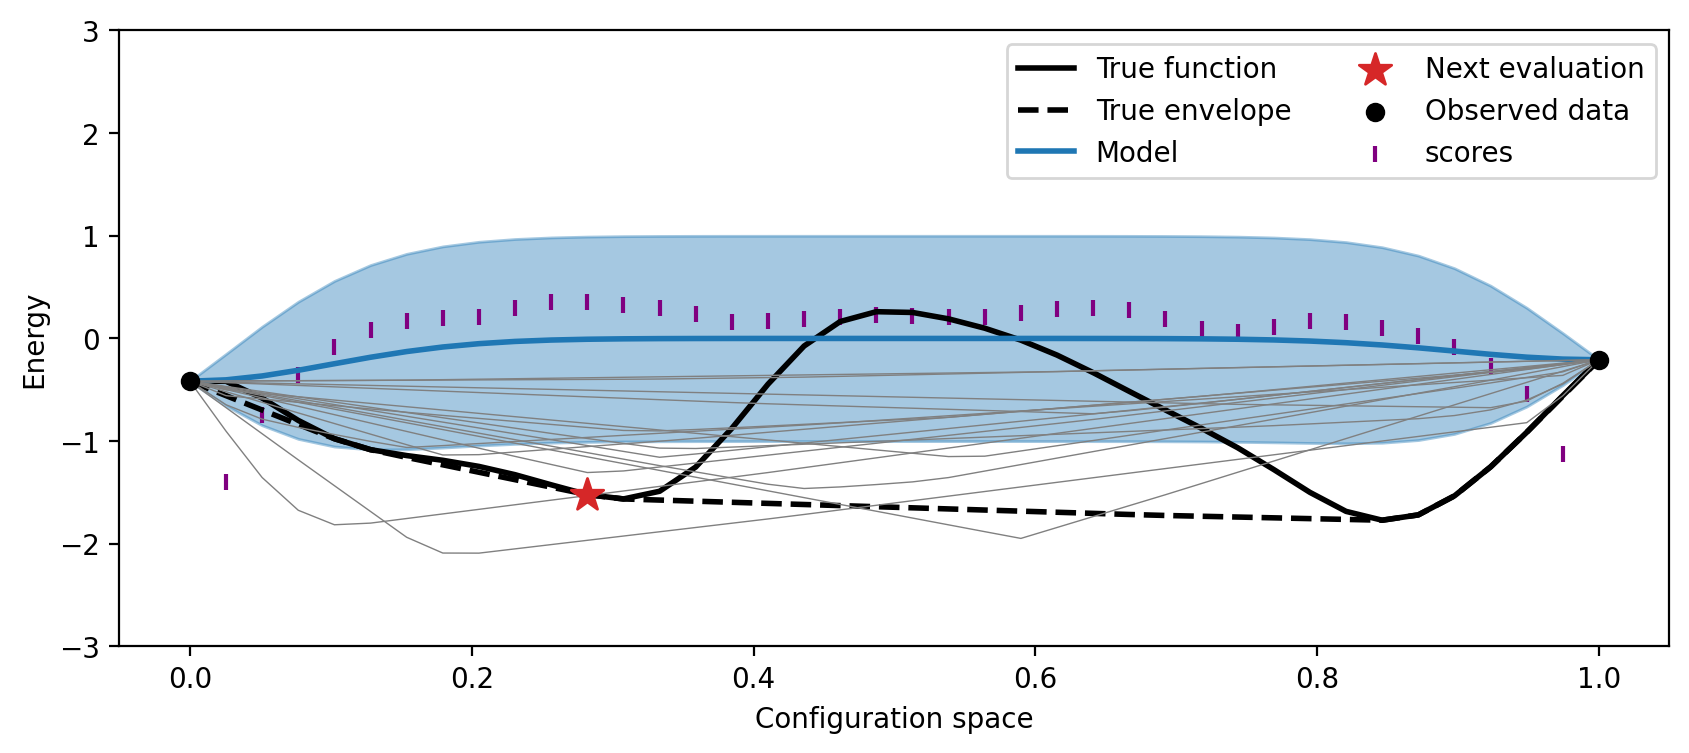

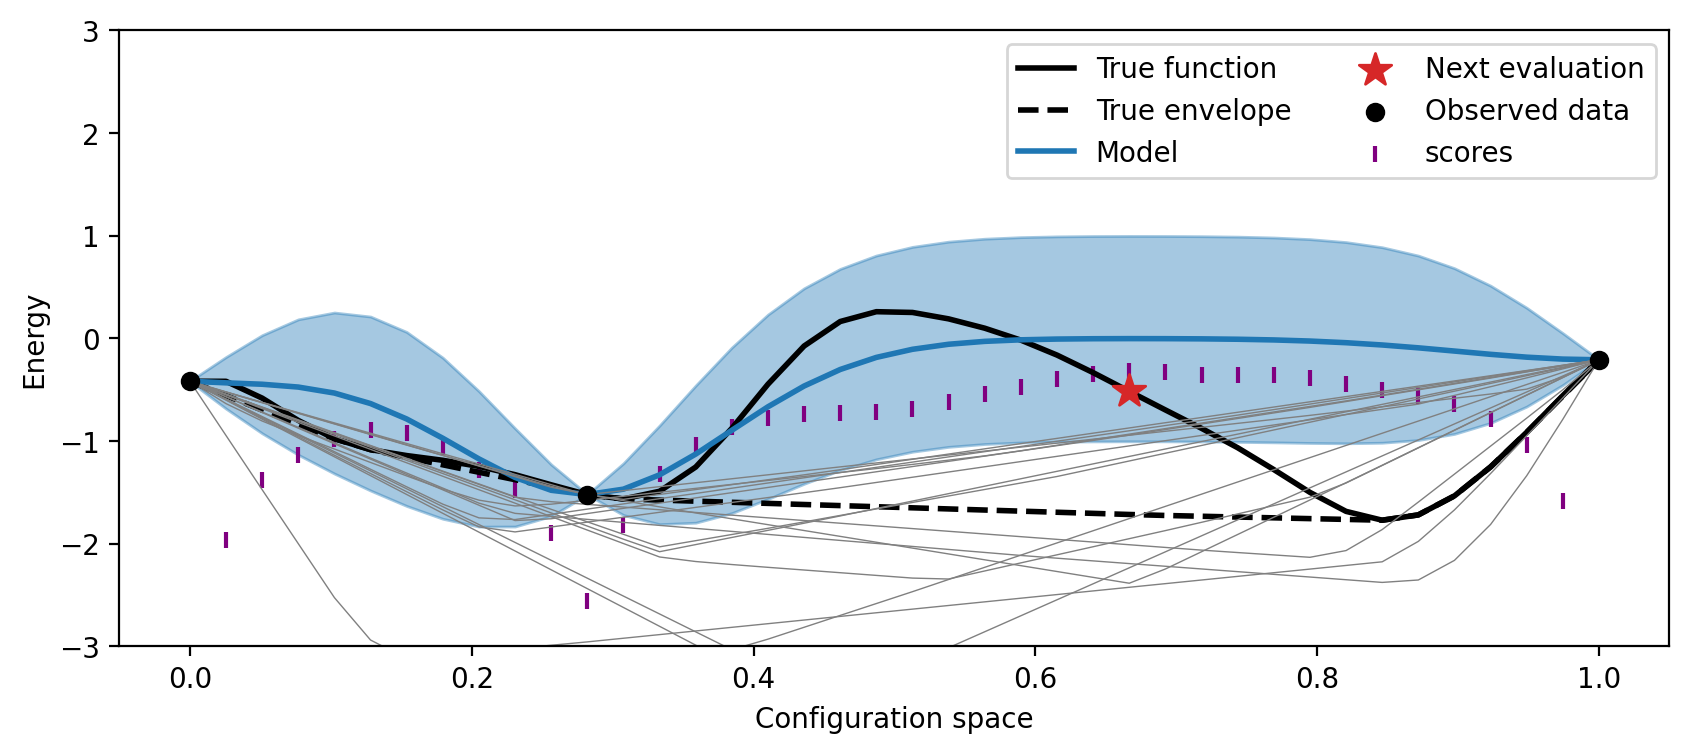

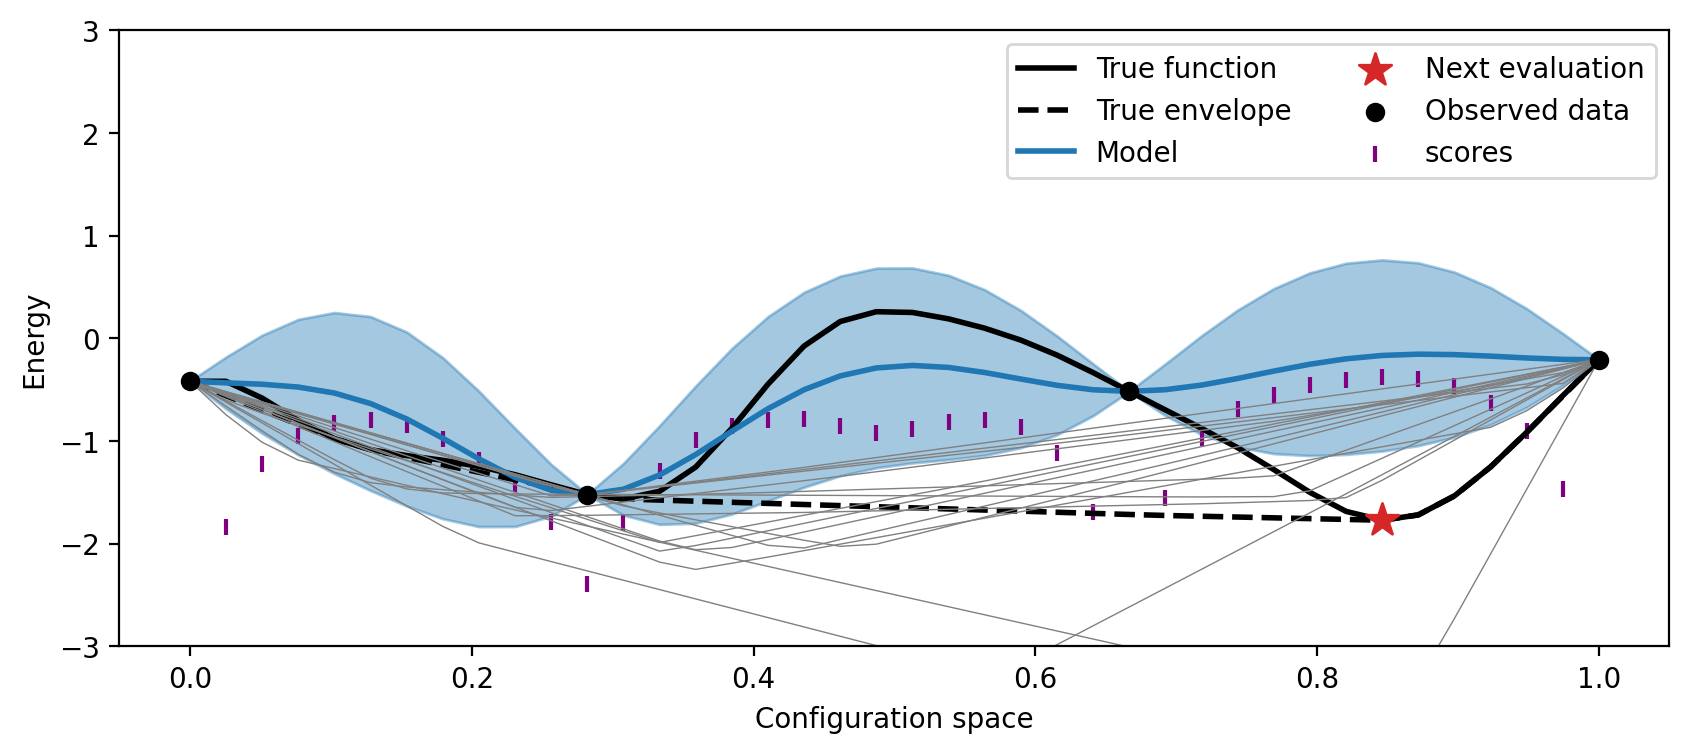

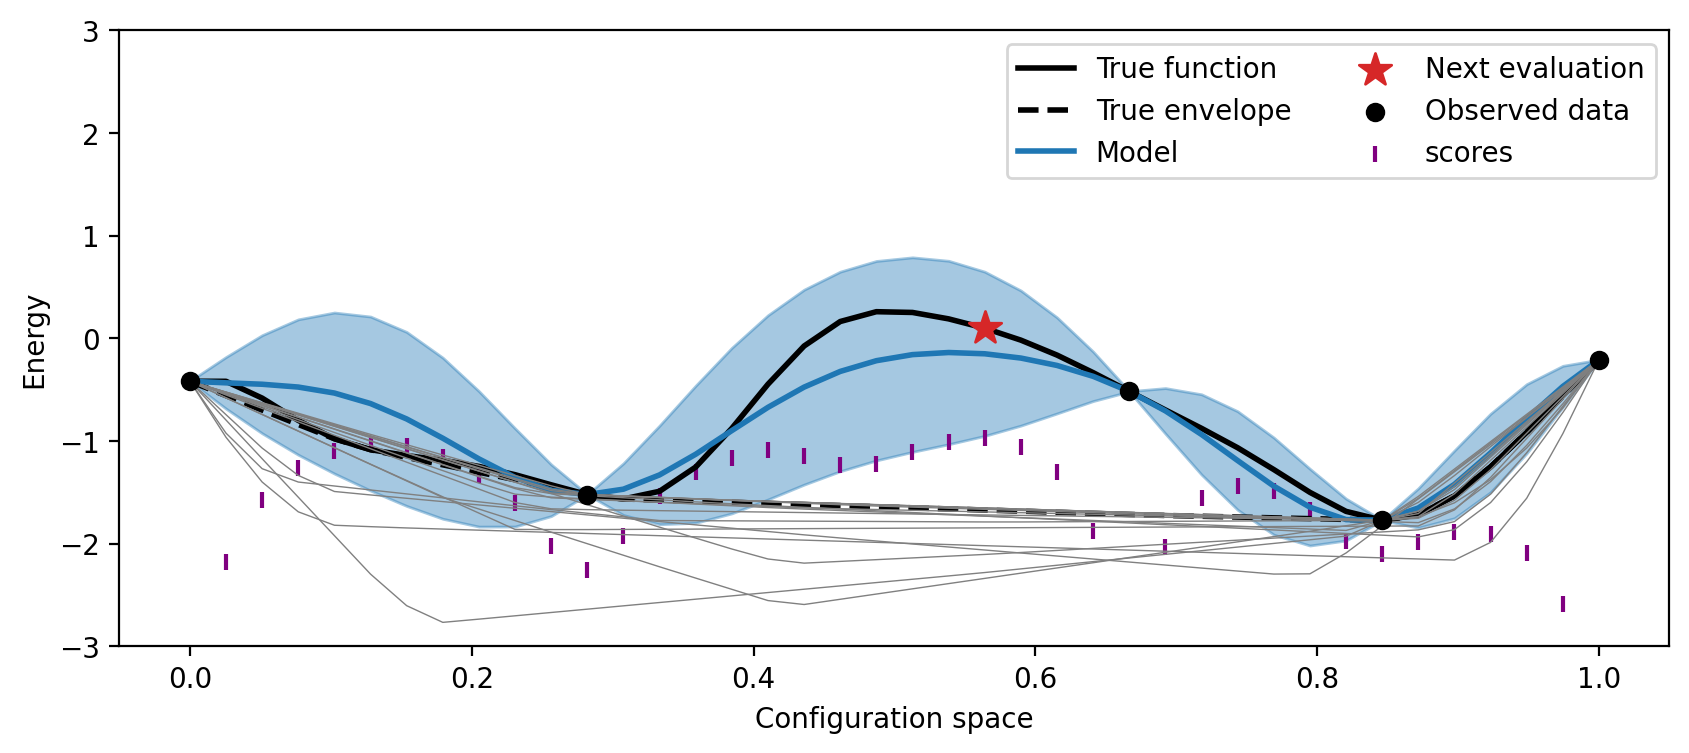

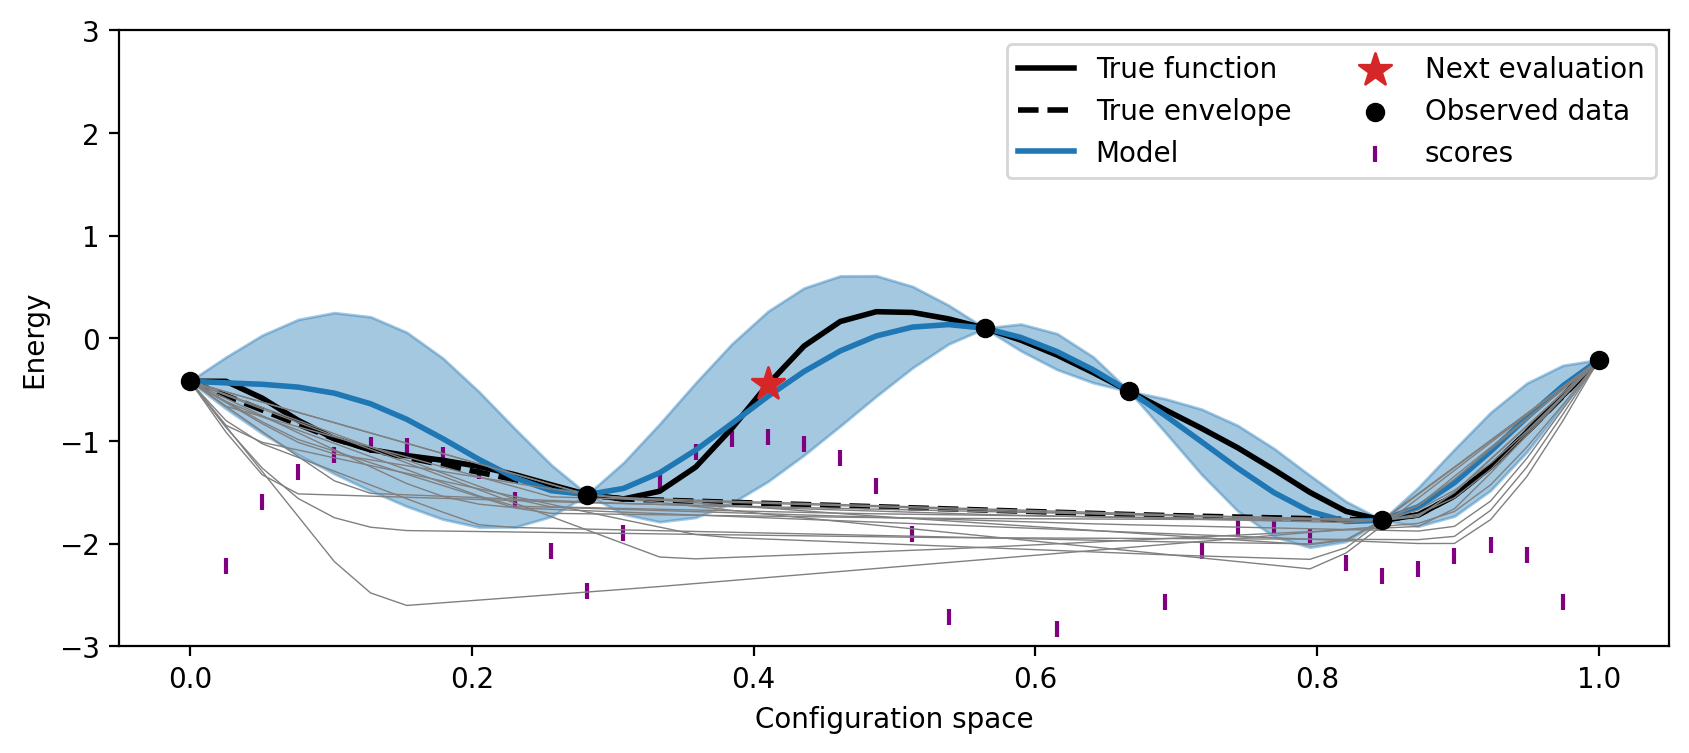

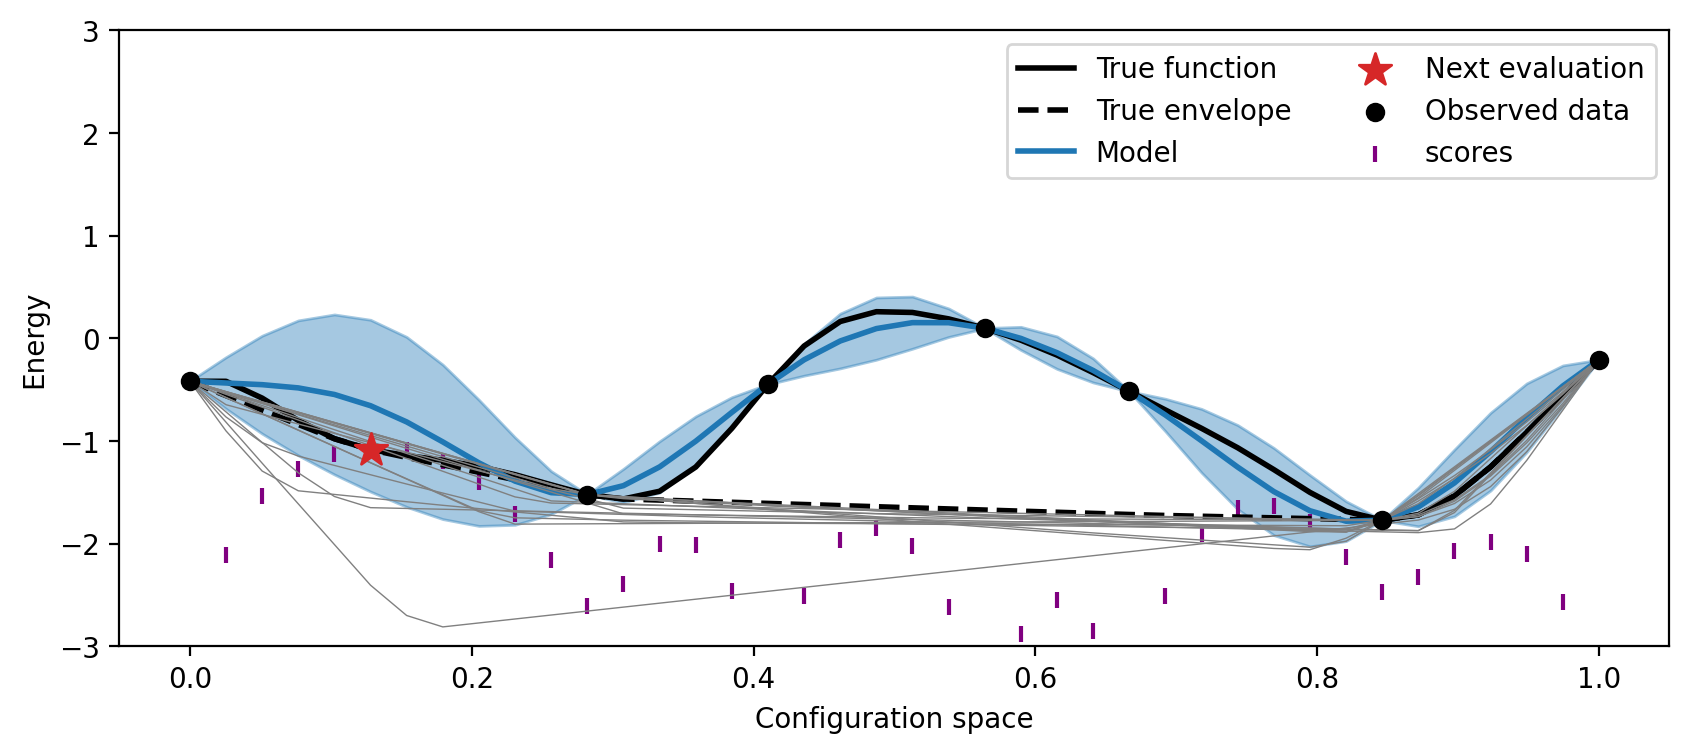

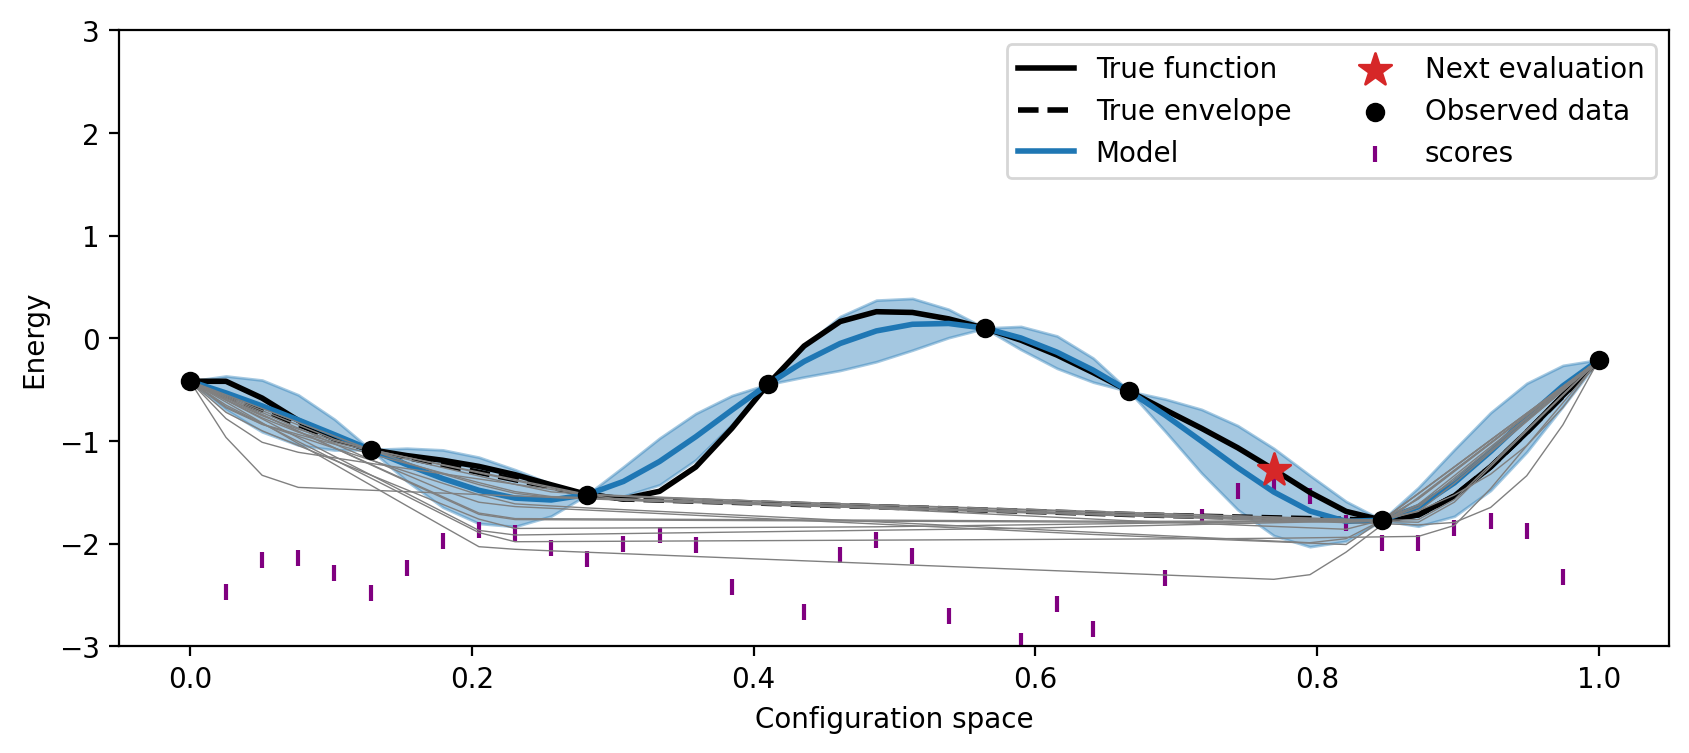

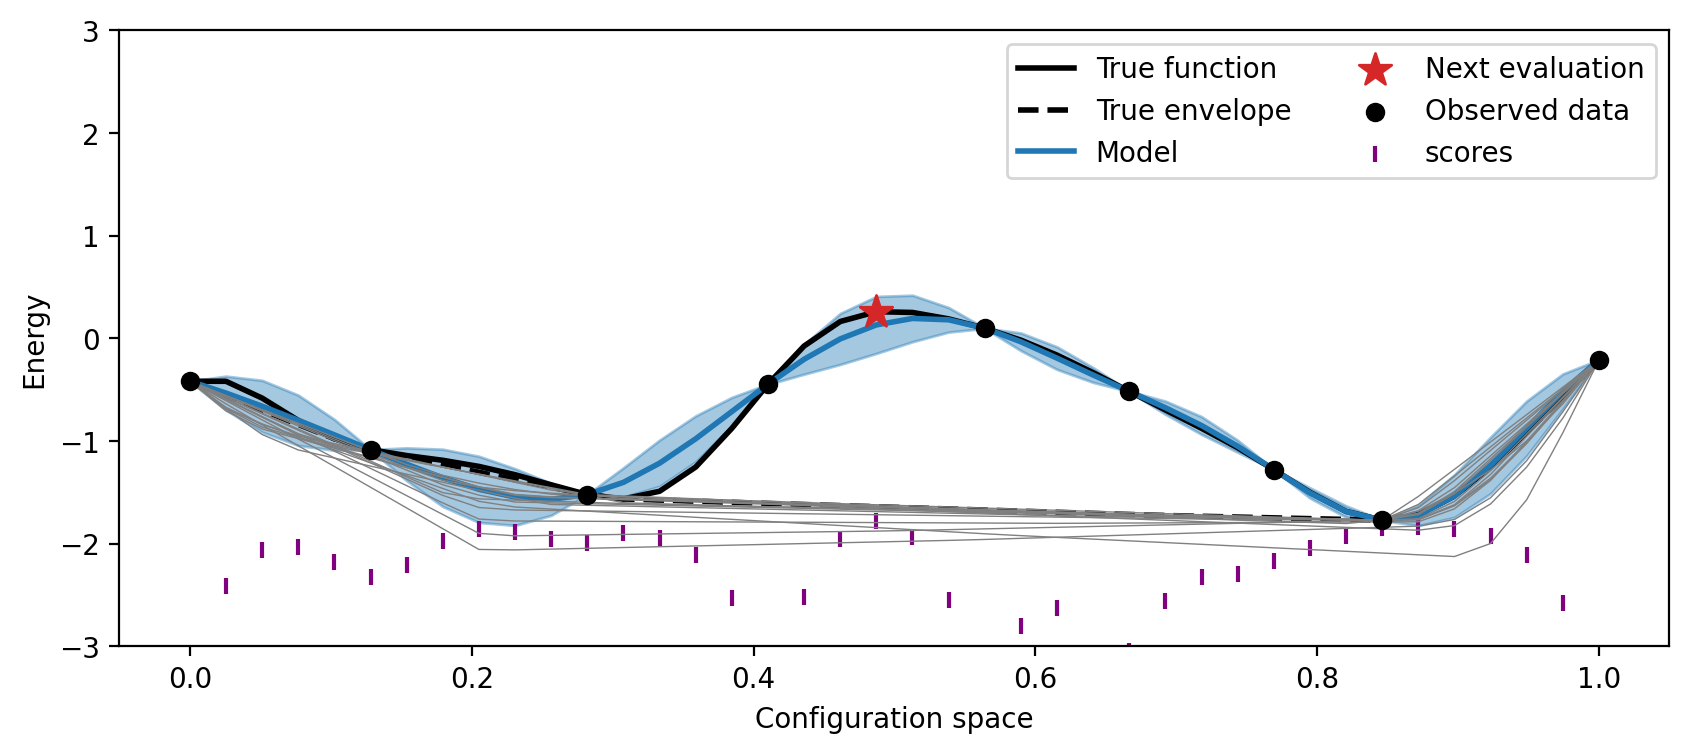

In [503]:
rng_key = jrnd.PRNGKey(1)

# Let's imagine that we start out by observing the two end points.
train_x = np.array([knot_x[0], knot_x[-1]])
train_y = np.array([true_y[0], true_y[-1]])

data = (train_x, train_y)


pred_mean, pred_cov, pred_cK, pred_Y, envelopes = update_model(data, knot_N)

num_iters = 8

for i in range(num_iters):
    print("Iteration: ", i)
    next_x, scores = get_next_candidate(data, knot_x, rng_key, T=30, J=40)
    plot_candidate(knot_x, true_y, true_envelope, pred_mean, pred_cov, envelopes, data, next_x, scores)
    
    # add observations to data
    train_x = np.concatenate([train_x, np.array([knot_x[next_x]])])
    train_y = np.concatenate([train_y, np.array([true_y[next_x]])])
    data = (train_x, train_y)
    
    pred_mean, pred_cov, pred_cK, pred_Y, envelopes = update_model(data, knot_N) # this is just for plotting...

### OLD CODE

In [485]:
%time next_x, scores = get_next_candidate(data, knot_x, rng_key, T=50, J=50)

CPU times: user 20.2 s, sys: 294 ms, total: 20.5 s
Wall time: 18.5 s


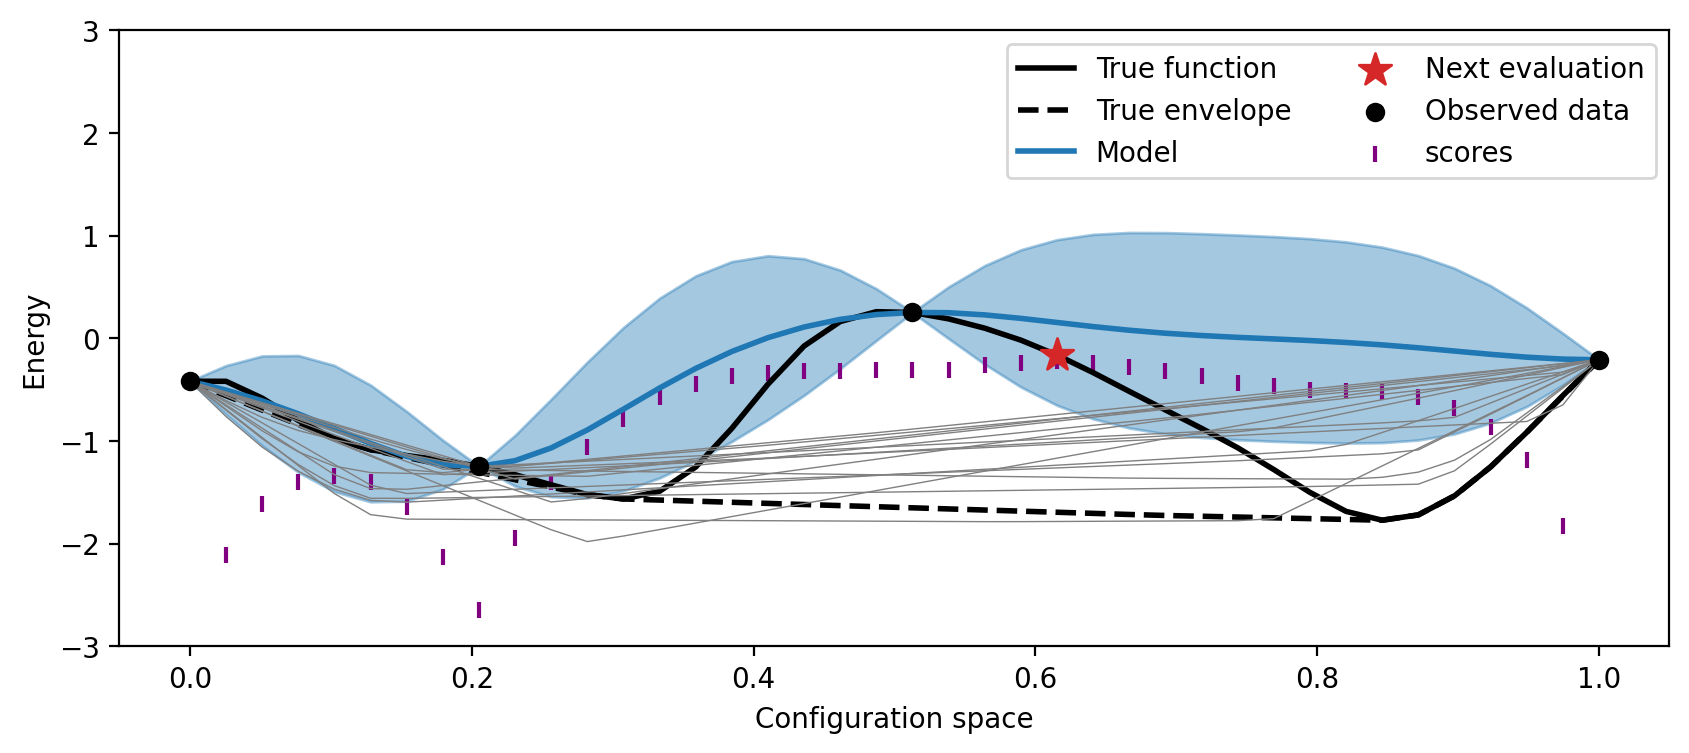

In [496]:
plot_candidate(knot_x, true_y, true_envelope, pred_mean, pred_cov, envelopes, data, next_x, scores)

In [492]:
train_x = np.concatenate([train_x, np.array([knot_x[next_x]])])
train_y = np.concatenate([train_y, np.array([true_y[next_x]])])
pred_mean, pred_cov, pred_cK, pred_Y, envelopes = update_model((train_x, train_y), knot_N) # this is just for plotting...
%time next_x, scores = get_next_candidate(data, knot_x, rng_key, T=50, J=50)

CPU times: user 22.2 s, sys: 395 ms, total: 22.6 s
Wall time: 20.6 s


Text(0, 0.5, 'Energy')

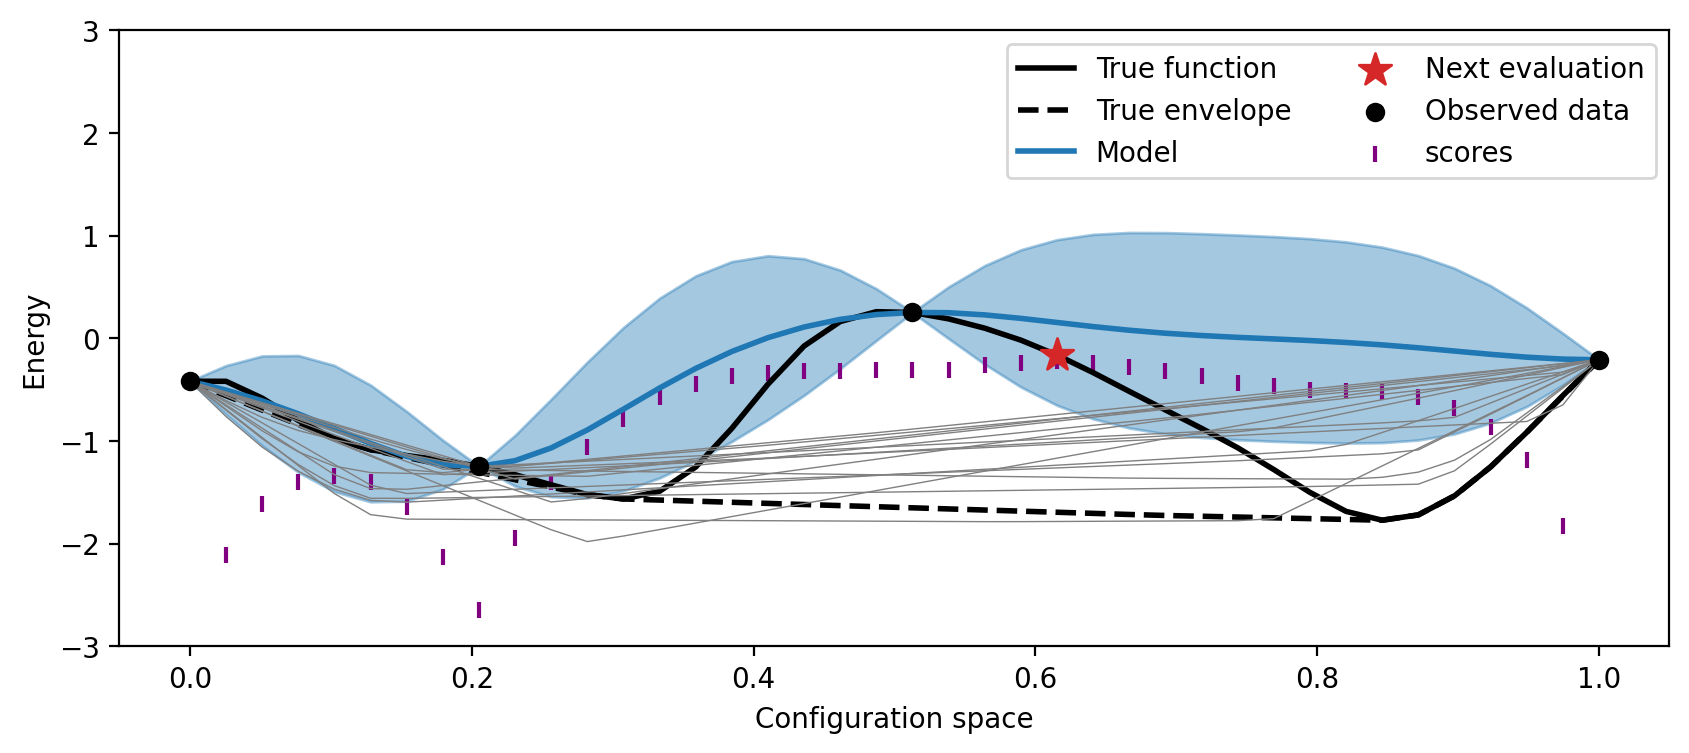

In [494]:
plt.figure(figsize=(10,4))

# Plot true function, convex hull, and GP model mean + uncertainty
plt.plot(knot_x, true_y, "k", lw=2, label="True function")
plt.plot(knot_x, true_envelope.T, ls="dashed", label="True envelope", lw=2, c="k")
plt.plot(knot_x, pred_mean, lw=2, c="tab:blue", label="Model")
y_err = np.sqrt(np.diag(pred_cov))
plt.fill_between(knot_x, pred_mean - y_err, pred_mean + y_err, alpha=0.4, color="tab:blue")
# Plot convex hulls of posterior samples
plt.plot(knot_x, envelopes[:15,:].T, lw=0.5, c="gray")

# Plot data / next evaluation
plt.scatter(knot_x[next_x], true_y[next_x], marker="*", color="tab:red", zorder=5, sizes=[150], label="Next evaluation")
plt.scatter(train_x, train_y, label="Observed data", c="k", zorder=5)
#plt.scatter(knot_x[1], true_y[1], marker="x", color="tab:red", zorder=5)

# Plot the entropy estimates (i.e., -second term of EIG)
plt.scatter(knot_x, scores, c="purple", marker="|", label="scores")

plt.ylim(-3,3); plt.legend(ncol=2); plt.xlabel("Configuration space"); plt.ylabel("Energy")

In [491]:
next_x

DeviceArray(20, dtype=int64)

In [ ]:
#####

/var/folders/4v/yjlz4wlj08n26k6x_vpckx500000gn/T/ipykernel_87691/4142804494.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(knot_x, pred_mean, 'b-', lw=2, c="tab:blue", label="Model")


Text(0, 0.5, 'Energy')

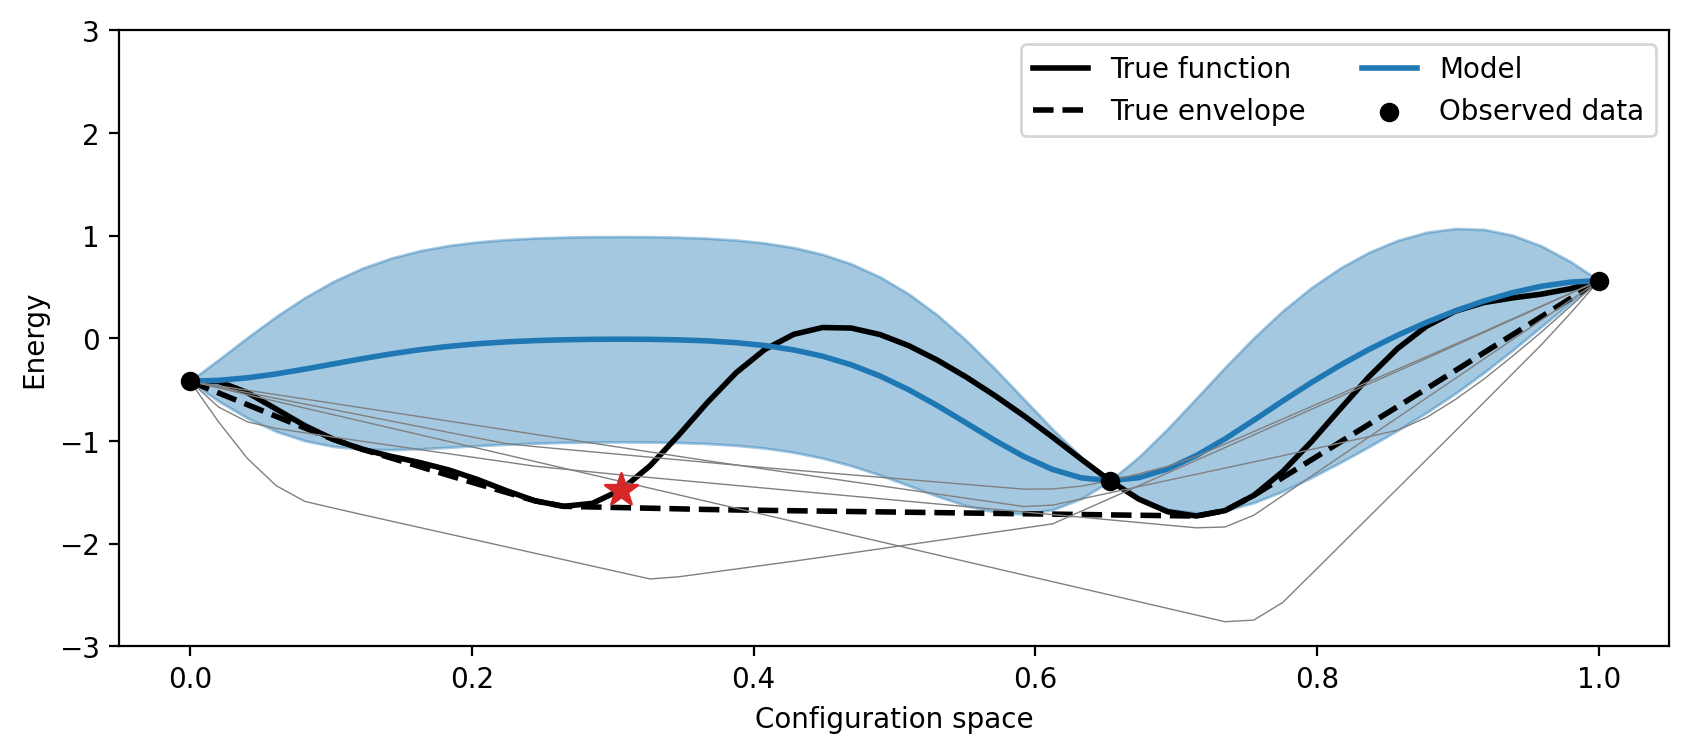

In [129]:
plt.figure(figsize=(10,4))

next_idx = scores.argmax()

plt.plot(knot_x, true_y, "k", lw=2, label="True function")
plt.plot(knot_x, true_envelope.T, ls="dashed", label="True envelope", lw=2, c="k")
plt.plot(knot_x, pred_mean, 'b-', lw=2, c="tab:blue", label="Model")
y_err = np.sqrt(np.diag(pred_cov))
plt.fill_between(knot_x, pred_mean - y_err, pred_mean + y_err, alpha=0.4, color="tab:blue")
#plt.plot(knot_x, pred_Y[:,:10], 'tab:blue', lw=0.5)
plt.plot(knot_x, envelopes[:5,:].T, lw=0.5, c="gray")


plt.scatter(train_x, train_y, label="Observed data", c="k", zorder=5)
plt.scatter(knot_x[next_idx], true_y[next_idx], marker="*", color="tab:red", zorder=5, sizes=[150])

plt.ylim(-3,3)
plt.legend(ncol=2)
plt.xlabel("Configuration space"); plt.ylabel("Energy")

In [143]:
# Let's imagine that we start out by observing the two end points.
train_x = np.array([knot_x[0],  knot_x[16], knot_x[32], knot_x[-1]])
train_y = np.array([true_y[0], true_y[16], true_y[32], true_y[-1]])

data = (train_x, train_y)

train_x, train_y = data
pred_mean, pred_cov = make_preds(train_x, train_y, knot_x); pred_cK = spla.cholesky(pred_cov)
# get samples from posterior
pred_Y = pred_cK.T @ npr.randn(knot_N, 6) + pred_mean[:,np.newaxis]
# compute envelopes based on samples from the predictive distribution
envelopes = convelope(knot_x, pred_Y.T)
# compute envelope based on true function
#true_envelope = convelope(knot_x, true_y)

new_designs = np.concatenate([knot_x[1:16], knot_x[17:32], knot_x[33:-1]])

In [148]:
next_x, scores = get_next_candidate(data, new_designs, rng_key, T=20, J=40)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:40<00:00,  2.00s/it]


/var/folders/4v/yjlz4wlj08n26k6x_vpckx500000gn/T/ipykernel_87691/2661451153.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(knot_x, pred_mean, 'b-', lw=2, c="tab:blue", label="Model")


Text(0, 0.5, 'Energy')

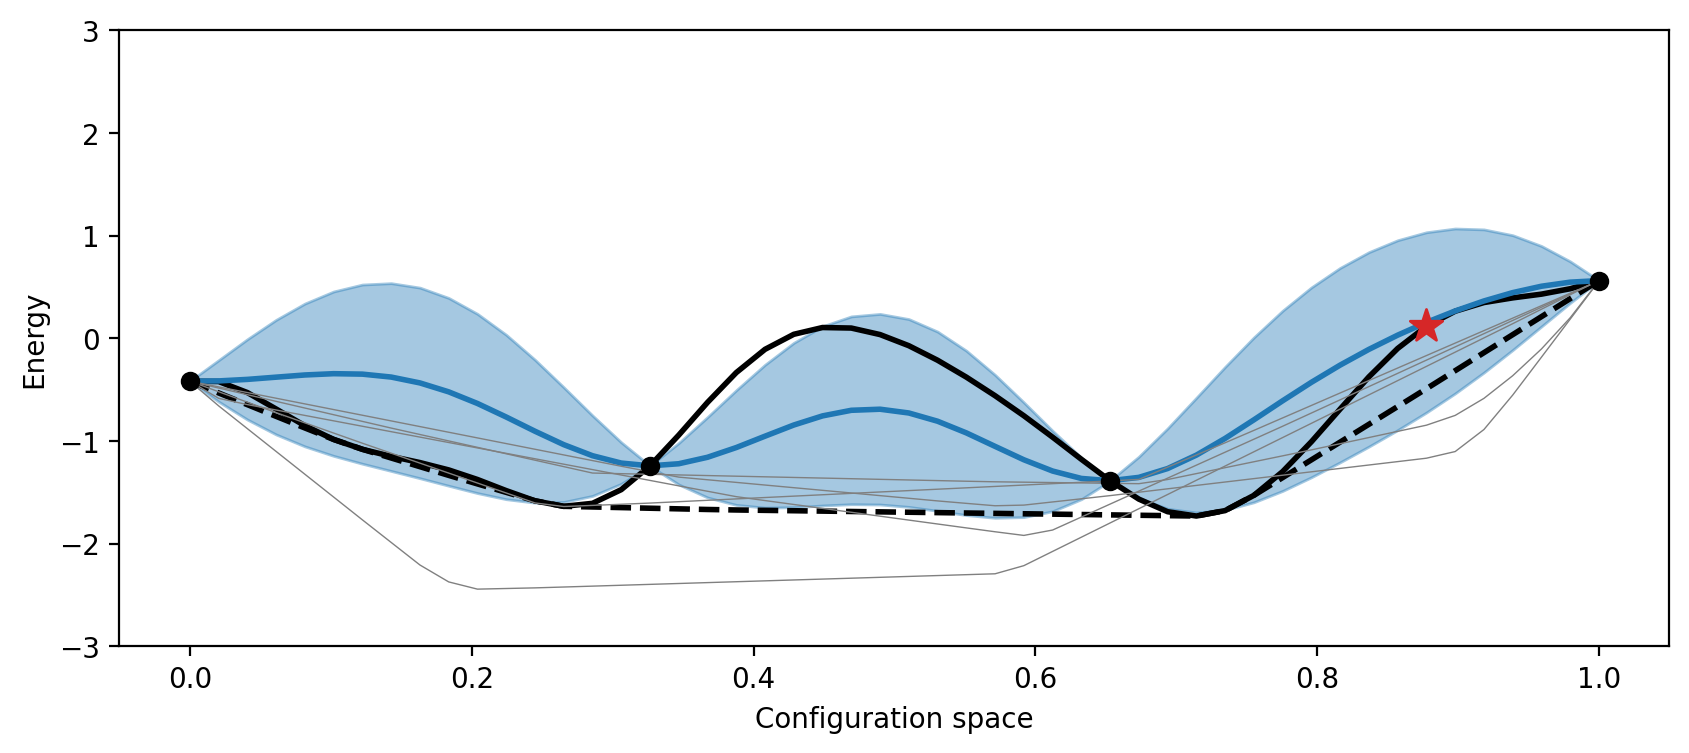

In [149]:
plt.figure(figsize=(10,4))

next_idx = scores.argmax()

plt.plot(knot_x, true_y, "k", lw=2, label="True function")
plt.plot(knot_x, true_envelope.T, ls="dashed", label="True envelope", lw=2, c="k")
plt.plot(knot_x, pred_mean, 'b-', lw=2, c="tab:blue", label="Model")
y_err = np.sqrt(np.diag(pred_cov))
plt.fill_between(knot_x, pred_mean - y_err, pred_mean + y_err, alpha=0.4, color="tab:blue")
#plt.plot(knot_x, pred_Y[:,:10], 'tab:blue', lw=0.5)
plt.plot(knot_x, envelopes[:5,:].T, lw=0.5, c="gray")


plt.scatter(train_x, train_y, label="Observed data", c="k", zorder=5)
plt.scatter(knot_x[next_idx], true_y[next_idx], marker="*", color="tab:red", zorder=5, sizes=[150])

plt.ylim(-3,3)
#plt.legend(ncol=2)
plt.xlabel("Configuration space"); plt.ylabel("Energy")

In [154]:
# Let's imagine that we start out by observing the two end points.
train_x = np.array([knot_x[0],  knot_x[16], knot_x[32],  knot_x[43], knot_x[-1]])
train_y = np.array([true_y[0], true_y[16], true_y[32],  true_y[43], true_y[-1]])

data = (train_x, train_y)

train_x, train_y = data
pred_mean, pred_cov = make_preds(train_x, train_y, knot_x); pred_cK = spla.cholesky(pred_cov)
# get samples from posterior
pred_Y = pred_cK.T @ npr.randn(knot_N, 6) + pred_mean[:,np.newaxis]
# compute envelopes based on samples from the predictive distribution
envelopes = convelope(knot_x, pred_Y.T)
# compute envelope based on true function
true_envelope = convelope(knot_x, true_y)

new_designs = np.concatenate([knot_x[1:16], knot_x[17:32], knot_x[33:43],  knot_x[44:-1]])

In [156]:
next_x, scores = get_next_candidate(data, new_designs, rng_key, T=20, J=40)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.47s/it]


/var/folders/4v/yjlz4wlj08n26k6x_vpckx500000gn/T/ipykernel_87691/2660150870.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(knot_x, pred_mean, 'b-', lw=2, c="tab:blue", label="Model")


Text(0, 0.5, 'Energy')

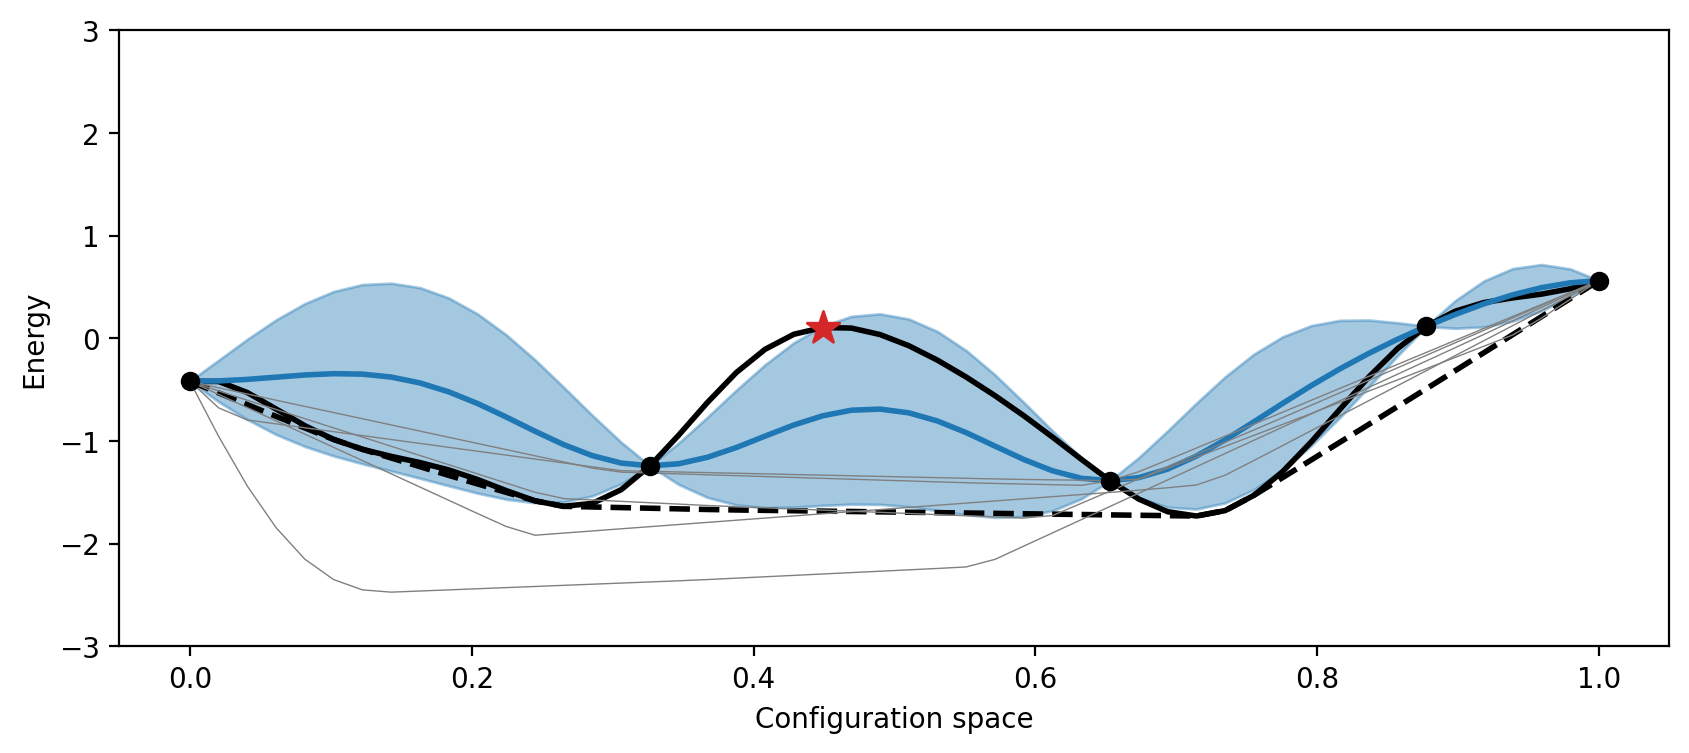

In [187]:
plt.figure(figsize=(10,4))

next_idx = scores.argmax()
next_idx = (knot_x==new_designs[next_idx]).argmax()

plt.plot(knot_x, true_y, "k", lw=2, label="True function")
plt.plot(knot_x, true_envelope.T, ls="dashed", label="True envelope", lw=2, c="k")
plt.plot(knot_x, pred_mean, 'b-', lw=2, c="tab:blue", label="Model")
y_err = np.sqrt(np.diag(pred_cov))
plt.fill_between(knot_x, pred_mean - y_err, pred_mean + y_err, alpha=0.4, color="tab:blue")
#plt.plot(knot_x, pred_Y[:,:10], 'tab:blue', lw=0.5)
plt.plot(knot_x, envelopes[:5,:].T, lw=0.5, c="gray")


plt.scatter(train_x, train_y, label="Observed data", c="k", zorder=5)
plt.scatter(knot_x[next_idx], true_y[next_idx], marker="*", color="tab:red", zorder=5, sizes=[150])

plt.ylim(-3,3)
#plt.legend(ncol=2)
plt.xlabel("Configuration space"); plt.ylabel("Energy")

/var/folders/4v/yjlz4wlj08n26k6x_vpckx500000gn/T/ipykernel_87691/33960776.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(knot_x, pred_mean, 'b-', lw=2, c="tab:blue", label="Model")


Text(0, 0.5, 'Energy')

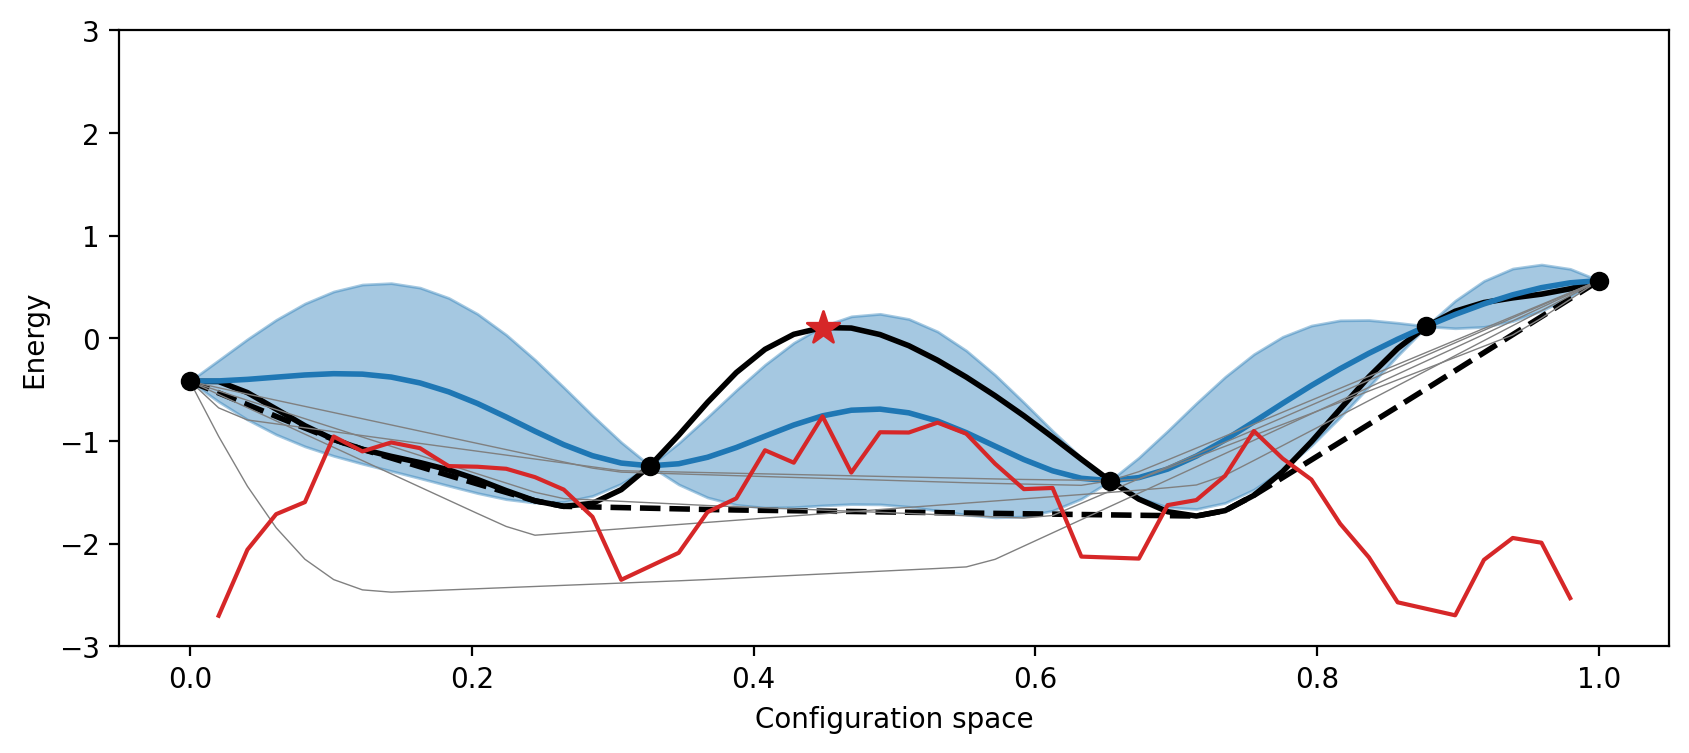

In [189]:
plt.figure(figsize=(10,4))

next_idx = scores.argmax()
next_idx = (knot_x==new_designs[next_idx]).argmax()

plt.plot(knot_x, true_y, "k", lw=2, label="True function")
plt.plot(knot_x, true_envelope.T, ls="dashed", label="True envelope", lw=2, c="k")
plt.plot(knot_x, pred_mean, 'b-', lw=2, c="tab:blue", label="Model")
y_err = np.sqrt(np.diag(pred_cov))
plt.fill_between(knot_x, pred_mean - y_err, pred_mean + y_err, alpha=0.4, color="tab:blue")
#plt.plot(knot_x, pred_Y[:,:10], 'tab:blue', lw=0.5)
plt.plot(knot_x, envelopes[:5,:].T, lw=0.5, c="gray")

#plt.plot(new_designs, scores, c="tab:red")


plt.scatter(train_x, train_y, label="Observed data", c="k", zorder=5)
plt.scatter(knot_x[next_idx], true_y[next_idx], marker="*", color="tab:red", zorder=5, sizes=[150])

plt.ylim(-3,3)
#plt.legend(ncol=2)
plt.xlabel("Configuration space"); plt.ylabel("Energy")

In [193]:
# Let's imagine that we start out by observing the two end points.
train_x = np.array([knot_x[0],  knot_x[16], knot_x[22], knot_x[32],  knot_x[43], knot_x[-1]])
train_y = np.array([true_y[0], true_y[16],true_y[22], true_y[32],  true_y[43], true_y[-1]])

data = (train_x, train_y)

train_x, train_y = data
pred_mean, pred_cov = make_preds(train_x, train_y, knot_x); pred_cK = spla.cholesky(pred_cov)
# get samples from posterior
pred_Y = pred_cK.T @ npr.randn(knot_N, 6) + pred_mean[:,np.newaxis]
# compute envelopes based on samples from the predictive distribution
envelopes = convelope(knot_x, pred_Y.T)
# compute envelope based on true function
true_envelope = convelope(knot_x, true_y)

new_designs = np.concatenate([knot_x[1:16], knot_x[17:22], knot_x[13:32], knot_x[33:43],  knot_x[44:-1]])

In [196]:
next_x, scores = get_next_candidate(data, new_designs, rng_key, T=30, J=50)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:52<00:00,  1.75s/it]


In [197]:
next_x

DeviceArray(5, dtype=int64)

/var/folders/4v/yjlz4wlj08n26k6x_vpckx500000gn/T/ipykernel_87691/866396140.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(knot_x, pred_mean, 'b-', lw=2, c="tab:blue", label="Model")


Text(0, 0.5, 'Energy')

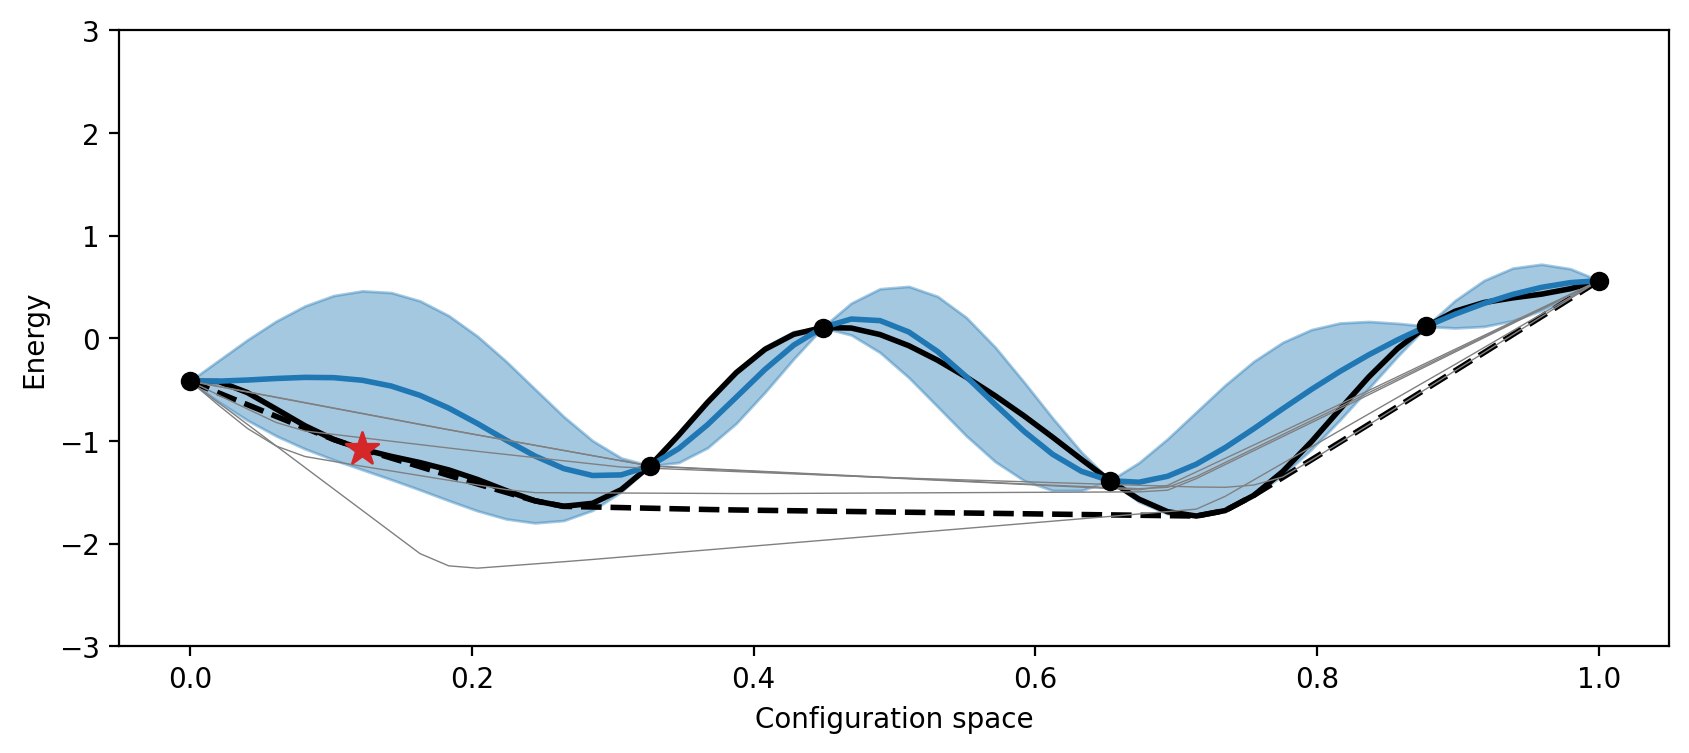

In [200]:
plt.figure(figsize=(10,4))

next_idx = scores.argmax()
next_idx = (knot_x==new_designs[next_idx]).argmax()

plt.plot(knot_x, true_y, "k", lw=2, label="True function")
plt.plot(knot_x, true_envelope.T, ls="dashed", label="True envelope", lw=2, c="k")
plt.plot(knot_x, pred_mean, 'b-', lw=2, c="tab:blue", label="Model")
y_err = np.sqrt(np.diag(pred_cov))
plt.fill_between(knot_x, pred_mean - y_err, pred_mean + y_err, alpha=0.4, color="tab:blue")
#plt.plot(knot_x, pred_Y[:,:10], 'tab:blue', lw=0.5)
plt.plot(knot_x, envelopes[:5,:].T, lw=0.5, c="gray")

#plt.plot(new_designs, scores, c="tab:red")


plt.scatter(train_x, train_y, label="Observed data", c="k", zorder=5)
plt.scatter(knot_x[next_idx], true_y[next_idx], marker="*", color="tab:red", zorder=5, sizes=[150])

plt.ylim(-3,3)
#plt.legend(ncol=2)
plt.xlabel("Configuration space"); plt.ylabel("Energy")